In [2]:
import excursion.utils as utils
from excursion import get_gp
import excursion.optimize as optimize
import numpy as np
import json
import requests
import scipy.stats
import excursion.plotting.twodim as plots
import os
np.warnings.filterwarnings('ignore')
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
truth0 = lambda X: requests.get('http://gateway.openfaas.svc.cluster.local:8080/function/yield', data = json.dumps({"X": X.tolist()})).json()

class scan(object):
    def __init__(self, functions):
        self.truth_functions = functions
        self.plot_rangedef = np.asarray([[0,1.5,101],[0,1.5,101]])
        self.plotG = utils.mgrid(self.plot_rangedef)
        self.plotX = utils.mesh2points(self.plotG,self.plot_rangedef[:,2])

        self.acq_rangedef = np.asarray([[0,1.5,21],[0,1.5,21]])
        self.acqG = utils.mgrid(self.acq_rangedef)
        self.acqX = utils.mesh2points(self.acqG,self.acq_rangedef[:,2])

        self.mean_rangedef = np.asarray([[0,1.5,21],[0,1.5,21]])
        self.meanG = utils.mgrid(self.mean_rangedef)
        self.meanX = utils.mesh2points(self.meanG,self.mean_rangedef[:,2])
        
        self.thresholds = [0]
    def invalid_region(self,X):
        return np.zeros(X.shape[0], dtype = 'bool')

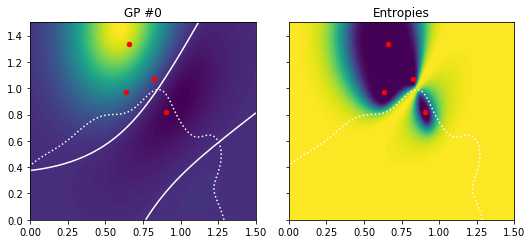

Iteration 1. new x: [[1.2   0.975]
 [0.225 0.675]]
Iteration 1. Evaluted function 0 to values: [1.7795210407945485, 3.685568637711024]


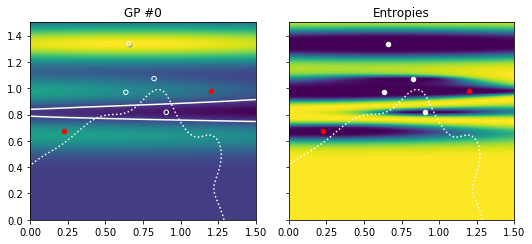

Iteration 2. new x: [[0.75  0.375]
 [0.75  0.075]]
Iteration 2. Evaluted function 0 to values: [-6.935475463498236, -8.527347319716645]


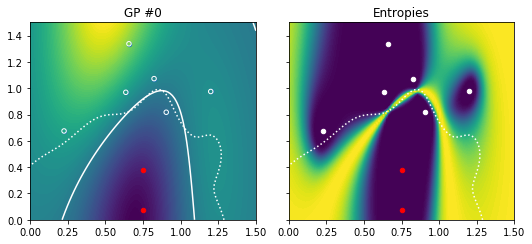

Iteration 3. new x: [[1.275 0.525]
 [0.225 0.3  ]]
Iteration 3. Evaluted function 0 to values: [0.1159963082116775, -8.634770096981756]


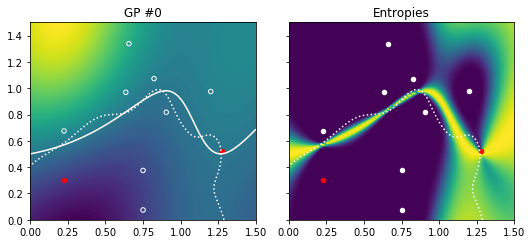

Iteration 4. new x: [[1.35  0.6  ]
 [1.2   1.275]]
Iteration 4. Evaluted function 0 to values: [2.317658747106339, 3.660454021347743]


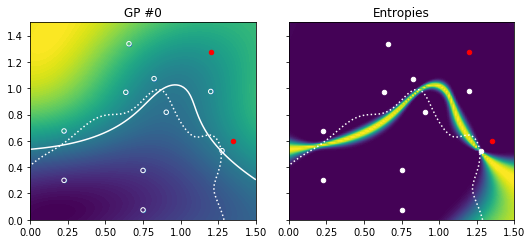

Iteration 5. new x: [[1.425 0.225]
 [0.15  0.6  ]]
Iteration 5. Evaluted function 0 to values: [4.7621455201264205, 3.0642528781328497]


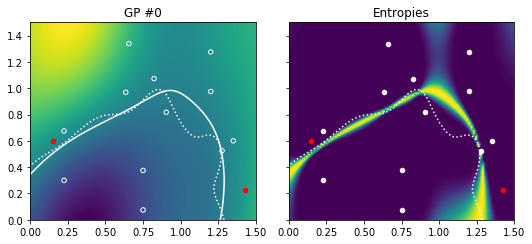

Iteration 6. new x: [[1.275 0.15 ]
 [0.9   1.125]]
Iteration 6. Evaluted function 0 to values: [0.576336520387378, 1.8877148922578235]


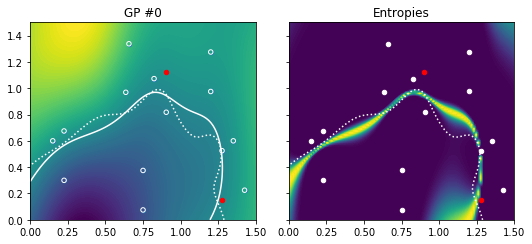

Iteration 7. new x: [[1.125 0.15 ]
 [1.2   0.45 ]]
Iteration 7. Evaluted function 0 to values: [-0.4393904748005171, -0.6865136024489109]


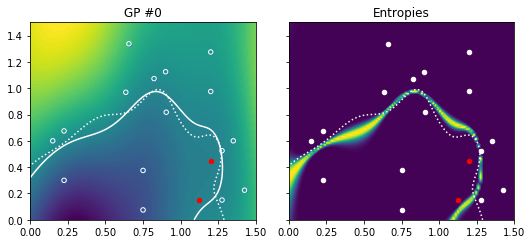

Iteration 8. new x: [[0.    0.3  ]
 [0.375 0.6  ]]
Iteration 8. Evaluted function 0 to values: [-5.043553541661963, -4.431963733488093]


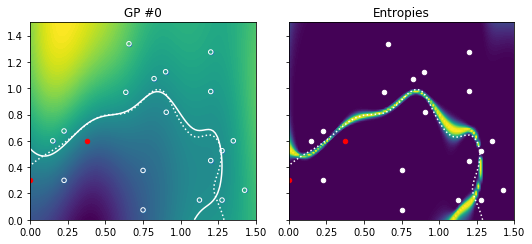

Iteration 9. new x: [[1.05  0.675]
 [0.    0.675]]
Iteration 9. Evaluted function 0 to values: [0.10245227489383701, 8.70901498419392]


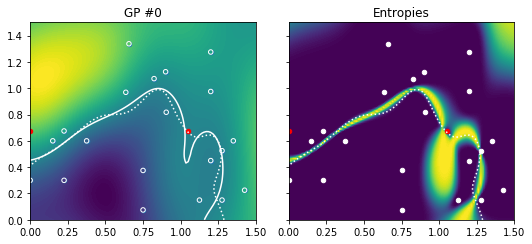

Iteration 10. new x: [[0.975 0.45 ]
 [1.425 1.35 ]]
Iteration 10. Evaluted function 0 to values: [-2.8865910453503907, 6.42587472199173]


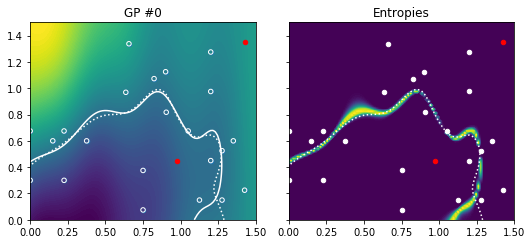

Iteration 11. new x: [[0.525 0.9  ]
 [1.275 0.3  ]]
Iteration 11. Evaluted function 0 to values: [2.7131537602931015, 0.6609916697698761]


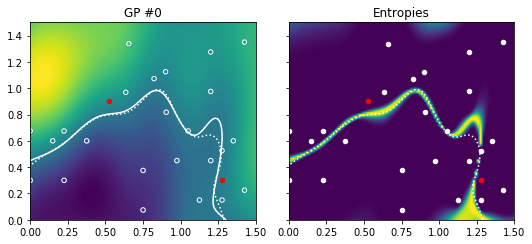

Iteration 12. new x: [[1.275 0.6  ]
 [0.15  1.425]]
Iteration 12. Evaluted function 0 to values: [0.4168945180116834, 8.987195841685638]


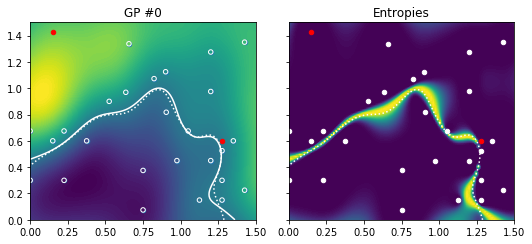

Iteration 13. new x: [[0.675 0.825]
 [0.975 0.9  ]]
Iteration 13. Evaluted function 0 to values: [-0.19182127269148053, 0.8845728452123813]


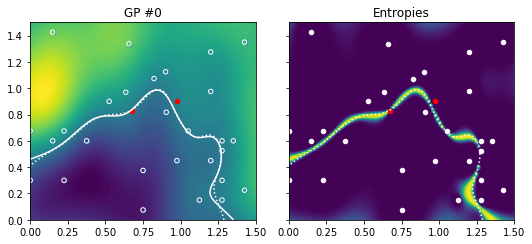

Iteration 14. new x: [[1.2   0.225]
 [1.35  0.075]]
Iteration 14. Evaluted function 0 to values: [-0.13275555786011983, 2.2408380690049827]


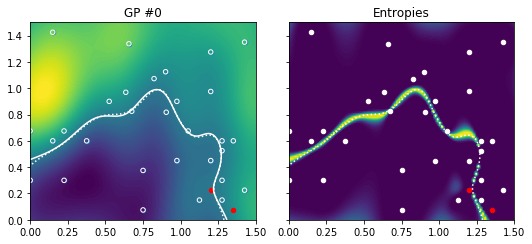

Iteration 15. new x: [[0.45  0.075]
 [0.375 0.   ]]
Iteration 15. Evaluted function 0 to values: [-14.031885929845286, -16.055337093409527]


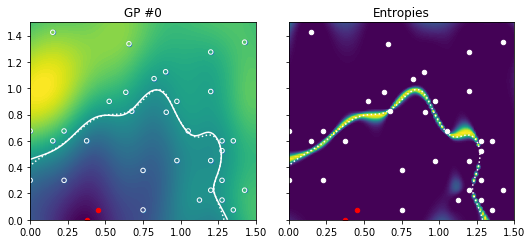

In [4]:
N_INIT  = 4
N_BATCH = 2
scandetails = scan([truth0])
X,y_list,gps = optimize.init(scandetails, seed = 0, n_init=N_INIT)

N_UPDATES = 15

def plot_and_save(workdir, index, *args,**kwargs):
    fig, axarr = plt.subplots(1, 2, sharey=True)
    fig.set_size_inches(7.5, 3.5)
    plt.title('Iteration {}'.format(index))
    plots.plot(axarr,gps,X,y_list,scandetails, **kwargs)
    plt.tight_layout()
    plt.savefig(os.path.join(workdir,'update_{}.png'.format(str(index).zfill(3))), bbox_inches = 'tight')
    plt.show()

workdir = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S-2dmulti')
os.mkdir(workdir)
index = 0
plot_and_save(workdir, index, gps,X,y_list,scandetails, batchsize = N_INIT)
for index in range(1,N_UPDATES+1):
    newx, acqvals = optimize.gridsearch(gps, X, scandetails, batchsize=N_BATCH)

    print('Iteration {}. new x: {}'.format(index, newx))
    newys_list = [func(newx) for func in scandetails.truth_functions]
    for i,newys in enumerate(newys_list):
        print('Iteration {}. Evaluted function {} to values: {}'.format(index, i,newys))
        y_list[i] = np.concatenate([y_list[i],newys])
    X = np.concatenate([X,newx])
    
    gps = [get_gp(X,y_list[i]) for i in range(len(scandetails.truth_functions))]
    plot_and_save(workdir, index, gps,X,y_list,scandetails, batchsize=N_BATCH)
